In [2]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [7]:
%%px
# Import the libraries

import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from FFT3Dfield import FFT3Dfield
from IFFT3Dfield import IFFT3Dfield
from EnergySpectrum import EnergySpectrum

In [8]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

In [4]:
%%px

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

[stdout:6] 
n_proc = 8
rank = 0


In [5]:
%%px 
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

In [6]:
%%px

vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = True

folder = "/home/idies/workspace/scratch"
filename = "cache-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    ud = []
    for k in range(slabs):
        if(rank==0):
            print(k)
        start = np.array([rank*nx+k*chkSz, 0, 0],dtype=np.int)
        width = np.array([chkSz,ny,nz],dtype=np.int)
        #start = np.array([ 0, 0, rank*nx+k*chkSz],dtype=np.int)
        ud.append(lJHTDB.getRawData(time,start,width, 
                                    data_set = 'isotropic1024coarse',
                                    getFunction = 'Velocity') )
    
    lJHTDB.finalize()
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    u = np.concatenate(ud,axis=2)
    comm.Barrier(); t1=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Concatenate: {0:.2f} seconds\n'.format(t1-t2))
    
    rsh = np.transpose(u,(2,1,0,3))
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Transpose: {0:.2f} seconds\n'.format(t2-t1))
    ##########################################
    
    vx[:,:,:] = rsh[:,:,:,0]
    vy[:,:,:] = rsh[:,:,:,1]
    vz[:,:,:] = rsh[:,:,:,2]
    comm.Barrier(); t1=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Splitting: {0:.2f} seconds\n'.format(t2-t1))
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

[stdout:6] 
Starting the loading process
Finished loading
Load from disk: 12.71 seconds
vx shape = (128, 1024, 1024)


In [7]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,rank)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate all wavenumbers: 12.03 seconds


In [8]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:
myFFT3Dfield=FFT3Dfield()
cvx=myFFT3Dfield.GetFFT3Dfield(vx,nx,ny,nz,nproc,rank)
cvy=myFFT3Dfield.GetFFT3Dfield(vy,nx,ny,nz,nproc,rank)
cvz=myFFT3Dfield.GetFFT3Dfield(vz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate 3D spatial FFT: 78.84 seconds


In [9]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cSxy=np.complex64(0.0+1.0j)*(kx*cvy+ky*cvx)
cSxz=np.complex64(0.0+1.0j)*(kx*cvz+kz*cvx)
cSyz=np.complex64(0.0+1.0j)*(ky*cvz+kz*cvy)

cSxx=np.complex64(0.0+1.0j)*(kx*cvx+kx*cvx)
cSyy=np.complex64(0.0+1.0j)*(ky*cvy+ky*cvy)
cSzz=np.complex64(0.0+1.0j)*(kz*cvz+kz*cvz)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate strain-rate in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate strain-rate in k space: 46.56 seconds


In [10]:
%%px
print((np.complex64(0.0+1.0j)*kx*cvx).shape)

[stdout:0] (128, 1024, 513)
[stdout:1] (128, 1024, 513)
[stdout:2] (128, 1024, 513)
[stdout:3] (128, 1024, 513)
[stdout:4] (128, 1024, 513)
[stdout:5] (128, 1024, 513)
[stdout:6] (128, 1024, 513)
[stdout:7] (128, 1024, 513)


In [11]:
%%px
comm.Barrier(); t1=MPI.Wtime()

ca11 = np.complex64(0.0+1.0j)*(kx*cvx)
ca22 = np.complex64(0.0+1.0j)*(ky*cvy)
ca33 = np.complex64(0.0+1.0j)*(kz*cvz)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate strain-rate in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate strain-rate in k space: 11.70 seconds


In [12]:
%%px

print(len(ca11[ca11==np.complex64(0.0+0.0j)].flatten()))

[stdout:0] 131072
[stdout:1] 131072
[stdout:2] 131072
[stdout:3] 131072
[stdout:4] 131072
[stdout:5] 131072
[stdout:6] 131072
[stdout:7] 131072


In [13]:
%%px
miFFT3Dfield=IFFT3Dfield()

In [20]:
%%px
tv=ft.zeros_aligned((nx,ny,nz), dtype='float32')
tcvt=ft.zeros_aligned((nx,ny,nz_half+1), dtype='complex64')

a11 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
a22 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
a33 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [23]:
%%px

print(len(ca11[ca11==np.complex64(0.0+0.0j)].flatten()))

[stdout:0] 67239936
[stdout:1] 67239936
[stdout:2] 67239936
[stdout:3] 67239936
[stdout:4] 67239936
[stdout:5] 67239936
[stdout:6] 67239936
[stdout:7] 67239936


In [21]:
%%px

comm.Barrier();
tv[:,:,:] = 0.; tcvt[:,:,:] = np.complex64(0.0+0.0j)
a11[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(ca11,tv,tcvt,nx,ny,nz,nproc,rank)
comm.Barrier(); 
tv[:,:,:] = 0.; tcvt[:,:,:] = np.complex64(0.0+0.0j)
a22[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(ca22,tv,tcvt,nx,ny,nz,nproc,rank)
comm.Barrier(); 
tv[:,:,:] = 0.; tcvt[:,:,:] = np.complex64(0.0+0.0j)
a33[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(ca33,tv,tcvt,nx,ny,nz,nproc,rank)
comm.Barrier(); 


In [22]:
%%px

print(len(a11[a11==0.].flatten()))
print(len(a22[a22==0.].flatten()))
print(len(a33[a33==0.].flatten()))

[stdout:0] 
134217728
2
3
[stdout:1] 
134217728
2
2
[stdout:2] 
134217728
6
2
[stdout:3] 
134217728
7
2
[stdout:4] 
134217728
4
0
[stdout:5] 
134217728
0
1
[stdout:6] 
134217728
5
4
[stdout:7] 
134217728
2
3


In [18]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:

#miFFT3Dfield=IFFT3Dfield()
Sxy=miFFT3Dfield.GetIFFT3Dfield(cSxy,nx,ny,nz,nproc,rank)
Sxz=miFFT3Dfield.GetIFFT3Dfield(cSxz,nx,ny,nz,nproc,rank)
Syz=miFFT3Dfield.GetIFFT3Dfield(cSyz,nx,ny,nz,nproc,rank)

Sxx=miFFT3Dfield.GetIFFT3Dfield(cSxx,nx,ny,nz,nproc,rank)
Syy=miFFT3Dfield.GetIFFT3Dfield(cSyy,nx,ny,nz,nproc,rank)
Szz=miFFT3Dfield.GetIFFT3Dfield(cSzz,nx,ny,nz,nproc,rank)

del cSxy
del cSxz
del cSyz
del cSxx
del cSyy
del cSzz

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

CompositeError: one or more exceptions from call to method: execute
[0:execute]: NameError: name 'cSxy' is not defined
[1:execute]: NameError: name 'cSxy' is not defined
[2:execute]: NameError: name 'cSxy' is not defined
[3:execute]: NameError: name 'cSxy' is not defined
.... 4 more exceptions ...

In [11]:
%%px
comm.Barrier(); t1=MPI.Wtime()

S2 = Sxx**2 + Syy**2 + Szz**2 + 2.*Sxy**2 + 2.*Sxz**2 + 2*Syz**2

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate average enstrophy: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Calculate average enstrophy: 29.86 seconds


In [6]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "dissp-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    S2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    S2[:,:,:] = content['S2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,S2=S2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] 
Finished loading
Load from disk: 11.78 seconds


In [7]:
%%px

avg_diss = np.average(S2)
avgDissGl=np.zeros(1,dtype='float32')

comm.Reduce([avg_diss,MPI.REAL],[avgDissGl,MPI.REAL],op=MPI.SUM)
avgDiss = avgDissGl[0]/nproc
avgDiss = comm.bcast(avgDiss, root=0)

In [8]:
%%px 

minS2 = S2.min()
maxS2 = S2.max()

minDissGl=np.zeros(nproc,dtype='float32')
maxDissGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minS2,MPI.REAL],[minDissGl,MPI.REAL])
comm.Allgather([maxS2,MPI.REAL],[maxDissGl,MPI.REAL])

minS2 = minDissGl.min()
maxS2 = maxDissGl.max()

comm.Barrier()

In [9]:
%%px

Nbins = 3200
s2histo=np.zeros(Nbins,dtype='int')
hist,edges = np.histogram(S2/avgDiss,np.linspace(minS2/avgDiss, maxS2/avgDiss, Nbins))

In [10]:
%%px 

blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([hist[i*100:(i+1)*100],MPI.INT],[s2histo[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:0]

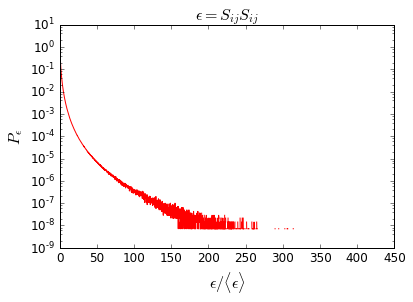

In [11]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
s2histo[-1] = 0
if rank==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.title(r'$\epsilon = S_{ij}S_{ij}$')
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')

    plt.semilogy(edges,s2histo*(1024**(-3))/((maxS2-minS2)/(avgDiss*Nbins)),'r',label='Unfiltered')

In [12]:
%%px
Nbins = 400
stemp = S2[S2<=20*avgDiss] 
s2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(stemp/avgDiss,np.linspace(minS2/avgDiss, 20, Nbins))

In [13]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[s2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:0]

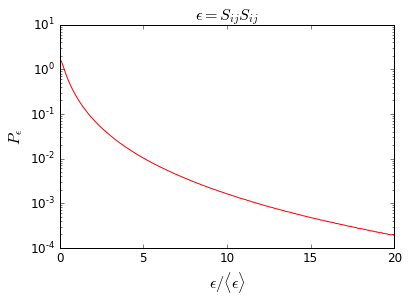

In [14]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.title(r'$\epsilon = S_{ij}S_{ij}$')
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((20*avgDiss-minS2)/(avgDiss*Nbins)),'r',label='Unfiltered')

In [15]:
%%px
Nbins = 400
stemp = S2[S2<=5*avgDiss] 
s2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(stemp/avgDiss,np.linspace(minS2/avgDiss, 5, Nbins))

In [16]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[s2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:0]

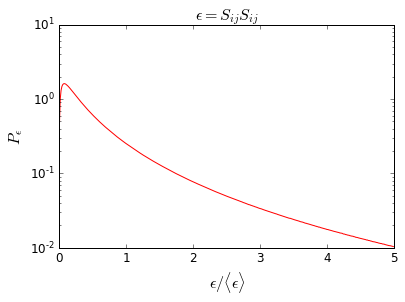

In [17]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.title(r'$\epsilon = S_{ij}S_{ij}$')
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((5*avgDiss-minS2)/(avgDiss*Nbins)),'r',label='Unfiltered')

In [18]:
%%px
Nbins = 400
stemp = S2[S2<=2*avgDiss] 
s2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(stemp/avgDiss,np.linspace(minS2/avgDiss, 2, Nbins))

In [19]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[s2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

In [1]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.title(r'$\epsilon = S_{ij}S_{ij}$')
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((5*avgDiss-minS2)/(avgDiss*Nbins)),'r',label='Unfiltered')
    plt.semilogy(S2_bins[S2_bins<=5],w2_pdf[S2_bins<=5],'b--')

ERROR: Cell magic `%%px` not found.
